In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import warnings
warnings.filterwarnings("ignore")

In [4]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [5]:
tr_df = train_df(r'C:\vit 7th semester\soft computing\dataset')

In [6]:
tr_df

,Class Path,Class
0,C:\vit 7th semester\soft computing\dataset\ang...,anger
1,C:\vit 7th semester\soft computing\dataset\ang...,anger
2,C:\vit 7th semester\soft computing\dataset\ang...,anger
3,C:\vit 7th semester\soft computing\dataset\ang...,anger
4,C:\vit 7th semester\soft computing\dataset\ang...,anger
...,...,...
1189,C:\vit 7th semester\soft computing\dataset\sad...,sad
1190,C:\vit 7th semester\soft computing\dataset\sad...,sad
1191,C:\vit 7th semester\soft computing\dataset\sad...,sad
1192,C:\vit 7th semester\soft computing\dataset\sad...,sad


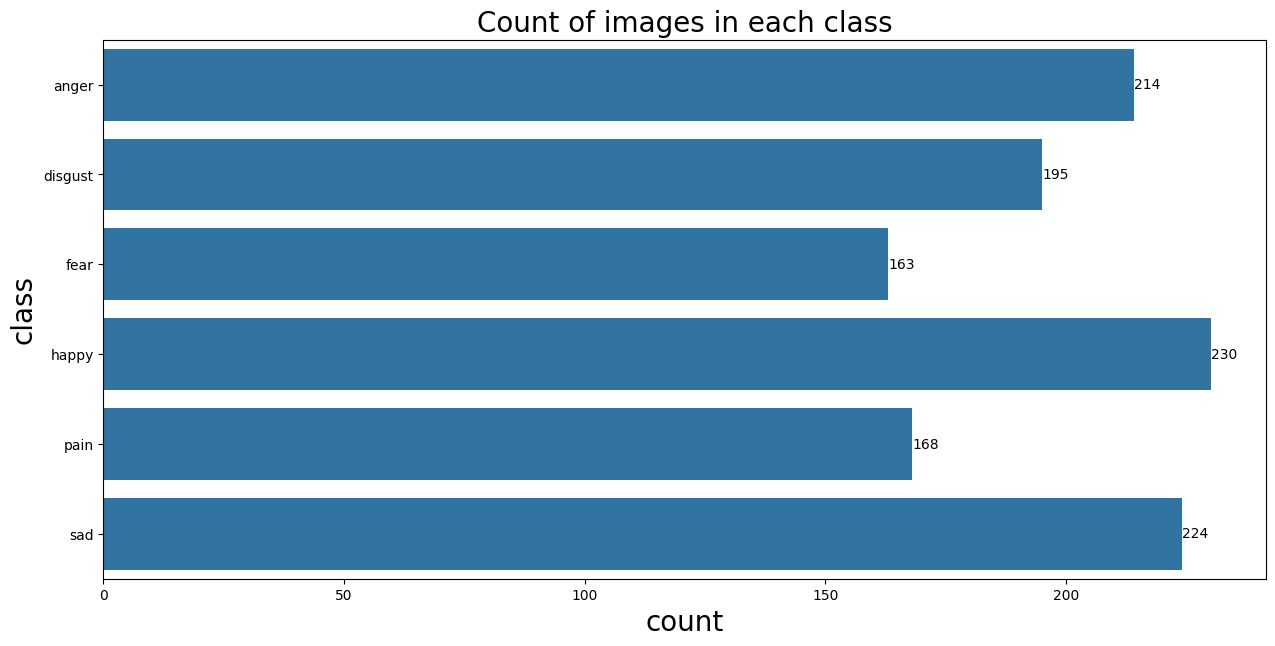

In [7]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('count',fontsize=20)
plt.ylabel('class',fontsize=20)
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [8]:
# 3. Split data into train, test and valid
tr_df, ts_df = train_test_split(tr_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [9]:
# 4. Preprocessing
batch_size = 16
img_size = (224, 224)
img_shape = (224, 224, 3)

gen = ImageDataGenerator(rotation_range=30,
                         shear_range=.1,
                         zoom_range=.1,
                         horizontal_flip=True)

ts_gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class', target_size=img_size,
                                 color_mode='rgb', shuffle=True,
                                 batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class', target_size=img_size,
                                    color_mode='rgb', shuffle=True,
                                    batch_size=batch_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', target_size=img_size,
                                    color_mode='rgb', shuffle=False,
                                    batch_size=batch_size)

Found 915 validated image filenames belonging to 6 classes.
Found 115 validated image filenames belonging to 6 classes.
Found 116 validated image filenames belonging to 6 classes.


In [10]:
# 5. Build Deep Learning Model (ResNet50)
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, weights="imagenet",
                      input_shape=img_shape, pooling='avg')

model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dropout(rate=0.4, seed=20),
    Dense(6, activation='softmax')
])

In [11]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# 6. Train the Model
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = model.fit(tr_gen, epochs=30,
                 validation_data=valid_gen,
                 callbacks=[tensorboard_callback])

Epoch 1/30
 5/58 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2069 - loss: 3.3053 - precision: 0.2054 - recall: 0.1498

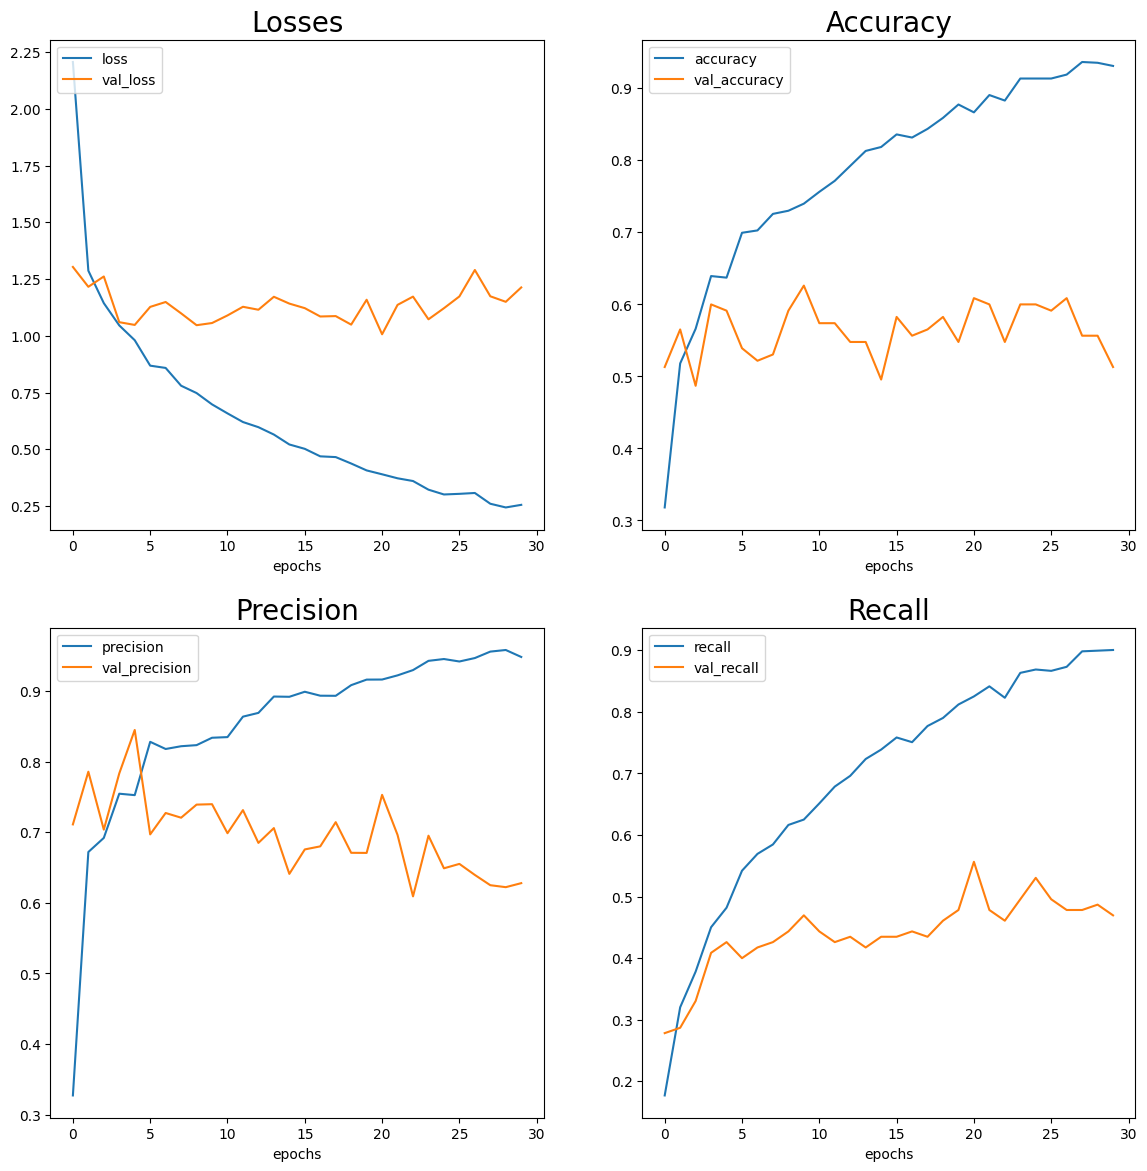

In [25]:
# 7. Plot Performance
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [27]:
# 8. Evaluate the Model
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9661 - loss: 0.1724 - precision: 0.9715 - recall: 0.9539
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5547 - loss: 1.2835 - precision: 0.6723 - recall: 0.4950
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6643 - loss: 1.2284 - precision: 0.6952 - recall: 0.6157
Train Loss:  0.16930164396762848
Train Accuracy:  0.9683060050010681
--------------------
Validation Loss:  1.328719973564148
Validation Accuracy:  0.539130449295044
--------------------
Test Loss:  1.143410086631775
Test Accuracy:  0.6551724076271057


In [29]:
# Predict and Generate Classification Report
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

# Get class names from the generator
classes = list(ts_gen.class_indices.keys())

print(classification_report(ts_gen.classes, y_pred, target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

       anger       0.48      0.75      0.59        16
     disgust       0.63      0.71      0.67        17
        fear       0.94      0.75      0.83        20
       happy       0.54      0.68      0.60        19
        pain       0.62      0.57      0.59        14
         sad       0.84      0.53      0.65        30

    accuracy                           0.66       116
   macro avg       0.67      0.67      0.66       116
weighted avg       0.70      0.66      0.66       116



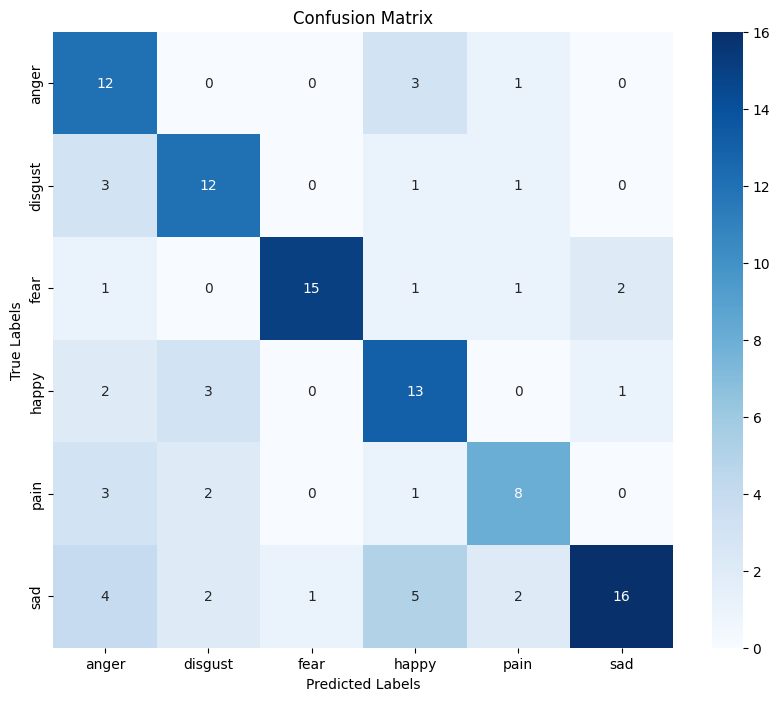

In [31]:
# Get class labels from the generator
labels = list(ts_gen.class_indices.keys())
# Compute the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [3]:
# Specify the directory where you want to save the model
save_dir = 'C:/Users/pavan/Desktop/emotion-classifier/models'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model to the specified directory
model.save(os.path.join(save_dir, 'model.h5'))

NameError: name 'model' is not defined